<a href="https://colab.research.google.com/github/igrosny/csca5642/blob/main/Slary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Topic

This project focuses on building a multiclass sentence classifier using a Recurrent Neural Network (RNN), specifically a Bidirectional LSTM architecture. This approach was chosen because RNNs, and LSTMs in particular, are well-suited for processing sequential data like text.

Text data consists of words in a specific order, where the meaning of a sentence is not just a sum of individual words but also depends on their sequence and context. Traditional models might struggle to capture these dependencies. RNNs, with their ability to maintain a hidden state that remembers information from previous words, are designed to handle this sequential nature. Bidirectional LSTMs further enhance this by processing the sequence in both forward and backward directions, allowing the model to capture context from both ends of a sentence, which is beneficial for understanding complex sentence structures and nuances in salary descriptions.

By using an Embedding layer with pre-trained GloVe embeddings, the model leverages existing knowledge about word relationships, providing a richer representation of the input text. The Dense and Dropout layers help in classifying the processed sequential information and preventing overfitting, respectively. This combination of RNN architecture and word embeddings provides a powerful approach for accurately classifying salary sentences into different categories.

In [29]:
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout





# Data
## Source
The dataset for this project was manually curated from job descriptions posted on Indeed. The data is available at the following URL: https://raw.githubusercontent.com/igrosny/master/refs/heads/main/new_salaries.tsv

Each entry in the dataset consists of a sentence related to salary, which has been manually classified into one of eleven distinct categories.

## Class Descriptions
The dataset is categorized into the following 11 classes based on the frequency or nature of the salary information provided in the job description:

* year: The salary is specified on an annual basis.
* month: The salary is specified on a monthly basis.
* week: The salary is specified on a weekly basis.
* biweekly: The salary is specified on a biweekly basis.
* day: The salary is specified on a daily basis.
* hour: The salary is specified on an hourly basis.
* task: The salary is based on the completion of specific tasks.
* extra: The sentence provides information about supplementary compensation or * benefits in addition to the base salary.
* sne: The salary frequency is not explicitly stated in the sentence.
* nd (No Digits): The sentence refers to salary but does not contain any numerical values.
* other: This class includes any sentences that do not fit into the aforementioned categories.

## Column Descriptions
The dataset is structured into the following columns:

* Job Title: The title of the job posting from which the sentence was extracted.
* Salary Sentence: The specific sentence containing salary-related information that serves as the input for analysis.
* Class: The target label representing the category to which the "Salary Sentence" belongs.

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/igrosny/master/refs/heads/main/new_salaries.tsv', sep='\t', header=None)

# add the columnames
df.columns = ['Job Title', 'Salary sentence', 'class']

In [2]:
# Display the first 5 rows of the DataFrame
print("First 5 rows of the DataFrame:")
print(df.head())

# Get information about the DataFrame (column names, data types, non-null values)
print("\nDataFrame Info:")
df.info()

# Get descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())

# Get value counts for categorical columns (first few columns for demonstration)
print("\nValue Counts for first few columns:")
for col in df.select_dtypes(include='object').columns[:5]:
    print(f"\nValue Counts for column: {col}")
    print(df[col].value_counts())

# Check for missing values
print("\nMissing Values per column:")
print(df.isnull().sum())


First 5 rows of the DataFrame:
              Job Title                                    Salary sentence  \
0    Property Inspector                               Pay  $15.00 per hour   
1  Facilities Inspector  Income Potential  Up to $55,000 (Including Ove...   
2  Facilities Inspector                          Pay  From $12.25 per hour   
3        Pipe Insulator                                             $22-28   
4        Pipe Insulator                       $65 night (double occupancy)   

   class  
0   hour  
1    sne  
2   hour  
3    sne  
4  extra  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Title        1014 non-null   object
 1   Salary sentence  1014 non-null   object
 2   class            1014 non-null   object
dtypes: object(3)
memory usage: 23.9+ KB

Descriptive Statistics:
                 Job

# Exploratory Data Analysis
Analyzing the target variable

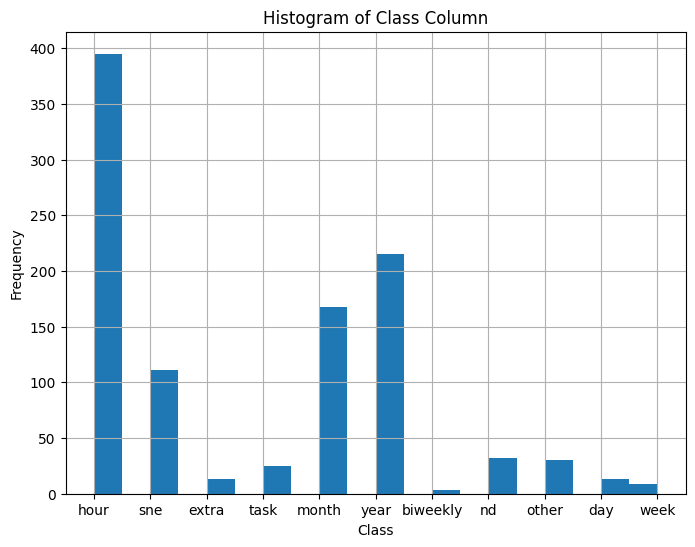

In [3]:
import matplotlib.pyplot as plt

# Create a histogram for the 'class' column
plt.figure(figsize=(8, 6))
df['class'].hist(bins=20)
plt.title('Histogram of Class Column')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

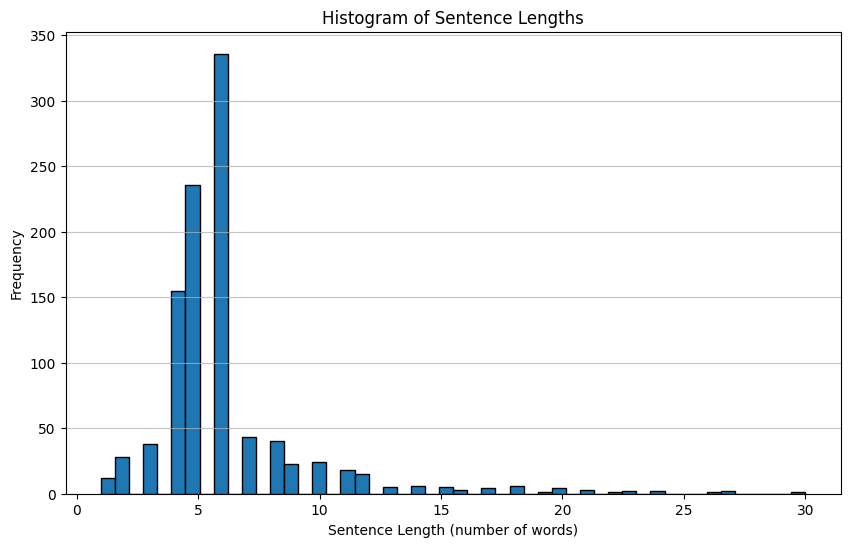

In [4]:
sentence_lengths = df['Salary sentence'].apply(lambda x: len(x.split()))

# Create a histogram for the sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title('Histogram of Sentence Lengths')
plt.xlabel('Sentence Length (number of words)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [5]:
print("\nStatistics of Sentence Lengths:")
print(sentence_lengths.describe())


Statistics of Sentence Lengths:
count    1014.000000
mean        6.193294
std         3.346126
min         1.000000
25%         5.000000
50%         6.000000
75%         6.000000
max        30.000000
Name: Salary sentence, dtype: float64


The analysis examines the length of 1,014 sentences, measured by the number of words. The findings indicate that the sentences are generally short and concise.

The distribution of sentence lengths is heavily right-skewed, with a significant concentration of sentences between 5 and 6 words long. This is supported by the descriptive statistics, which show a mean sentence length of approximately 6.2 words and a median of 6 words.

Furthermore, 75% of the sentences contain 6 words or fewer, confirming the prevalence of short sentences. While the longest sentence contains 30 words, such instances are rare, as illustrated by the long tail in the histogram. In summary, the dataset is characterized by brief sentences, with the vast majority being 6 words or less.

# Model

Found 224648 word vectors.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,571 (4.31 MB)

 Trainable params: 130,571 (510.04 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.2638 - loss: 2.1721 - val_accuracy: 0.3865 - val_loss: 1.6341
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.4514 - loss: 1.6773 - val_accuracy: 0.6626 - val_loss: 1.1699
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.6808 - loss: 1.0970 - val_accuracy: 0.6810 - val_loss: 0.9647
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.6876 - loss: 1.0319 - val_accuracy: 0.7546 - val_loss: 0.8099
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.7753 - loss: 0.8664 - val_accuracy: 0.7791 - val_loss: 0.6967
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.7893 - loss: 0.7597 - val_accuracy: 0.8405 - val_loss: 0.5803
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.8431 - loss: 0.5947 - val_accuracy: 0.8160 - val_loss: 0.6002
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.8855 - loss: 0.4802 - val_accuracy: 0

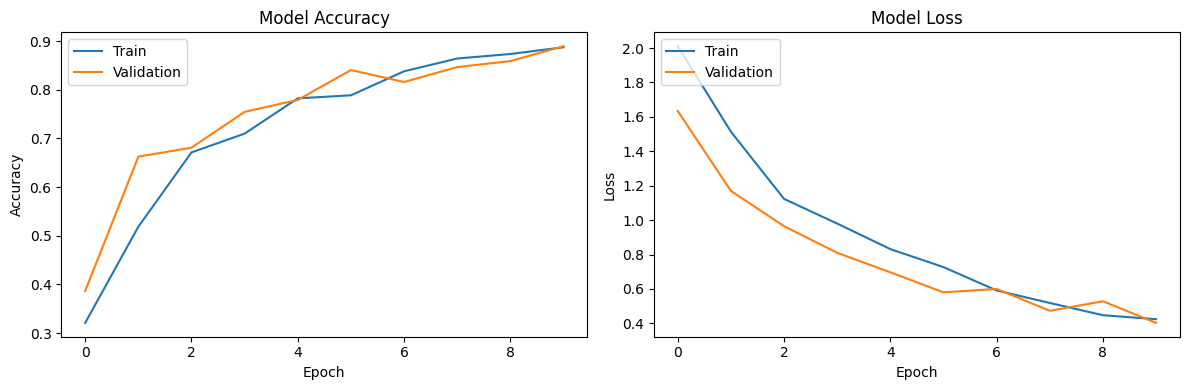

In [8]:
glove_file = '/content/glove.6B.100d.txt'

# Load the GloVe embeddings
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

# Prepare text data
texts = df['Salary sentence'].values
labels = df['class'].values

# Tokenize the text
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences
maxlen = 20
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Create the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(np.unique(encoded_labels))
encoded_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42,stratify=encoded_labels )

# Build the model
model = Sequential([
    Input(shape=(maxlen,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


<Figure size 1000x800 with 0 Axes>

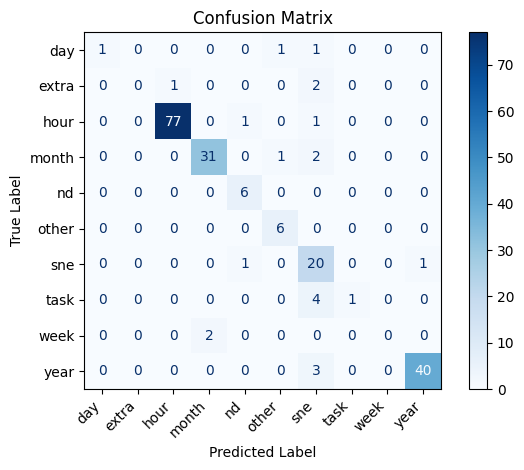


Number of errors per class:
Class 'day': 2 errors
Class 'extra': 3 errors
Class 'hour': 2 errors
Class 'month': 3 errors
Class 'nd': 0 errors
Class 'other': 0 errors
Class 'sne': 2 errors
Class 'task': 4 errors
Class 'week': 2 errors
Class 'year': 3 errors

Class with the most errors: 'task' with 4 errors.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder #
# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
unique_true_classes = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=unique_true_classes)


display_class_labels = label_encoder.inverse_transform(unique_true_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze which class got the most errors
errors_per_class = cm.sum(axis=1) - np.diag(cm)

print("\nNumber of errors per class:")
for i, count in enumerate(errors_per_class):
    print(f"Class '{display_class_labels[i]}': {count} errors")

most_errors_class_index = np.argmax(errors_per_class)
most_errors_class_label = display_class_labels[most_errors_class_index]
most_errors_count = errors_per_class[most_errors_class_index]

print(f"\nClass with the most errors: '{most_errors_class_label}' with {most_errors_count} errors.")

In [12]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt


X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

def build_model(hp):
    """
    Builds a compiled Keras model with tunable hyperparameters.
    """
    model = Sequential()
    model.add(Input(shape=(maxlen,)))
    model.add(Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False
    ))

    # Tune the number of units in the first Bidirectional LSTM layer
    hp_lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(hp_lstm_units_1, return_sequences=True)))

    # Tune the number of units in the second Bidirectional LSTM layer
    hp_lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
    model.add(Bidirectional(LSTM(hp_lstm_units_2)))

    # Tune the number of units in the Dense layer
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(hp_dense_units, activation='relu'))

    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)
    model.add(Dropout(hp_dropout))

    model.add(Dense(num_classes, activation='softmax'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # The metric to optimize
    max_trials=10,             # Total number of hyperparameter combinations to test
    executions_per_trial=2,    # Number of models to train per trial to reduce variance
    directory='my_dir',        # Directory to store the results
    project_name='multiclass_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')},
the optimal number of units in the second LSTM layer is {best_hps.get('lstm_units_2')},
the optimal number of units in the dense layer is {best_hps.get('dense_units')},
the optimal dropout rate is {best_hps.get('dropout')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 10 Complete [00h 06m 36s]
val_accuracy: 0.89570552110672

Best val_accuracy So Far: 0.9110429286956787
Total elapsed time: 00h 59m 00s

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 128,
the optimal number of units in the second LSTM layer is 32,
the optimal number of units in the dense layer is 128,
the optimal dropout rate is 0.4,
and the optimal learning rate for the optimizer is 0.001.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9458 - loss: 0.2087 - val_accuracy: 0.9015 - val_loss: 0.3089
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.9374 - loss: 0.2084 - val_accuracy: 0.9212 - val_loss: 0.2781
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.9534 - loss: 0.1585 - val_accuracy: 0.9064 - val_loss: 0.3885
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step - accuracy: 0.9659 - loss: 0.1121 - val_accuracy: 0.8916 - val_loss: 0.3602
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - accuracy: 0.9409 - loss: 0.1814 - val_accuracy: 0.9458 - val_loss: 0.2650
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9669 - loss: 0.1240 - val_accuracy: 0.9113 - val_loss: 0.3621
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - accuracy: 0.9598 - loss: 0.1205 - val_accuracy: 0.9360 - val_loss: 0.2749
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.9755 - loss: 0.0872 - val_accuracy: 0.936

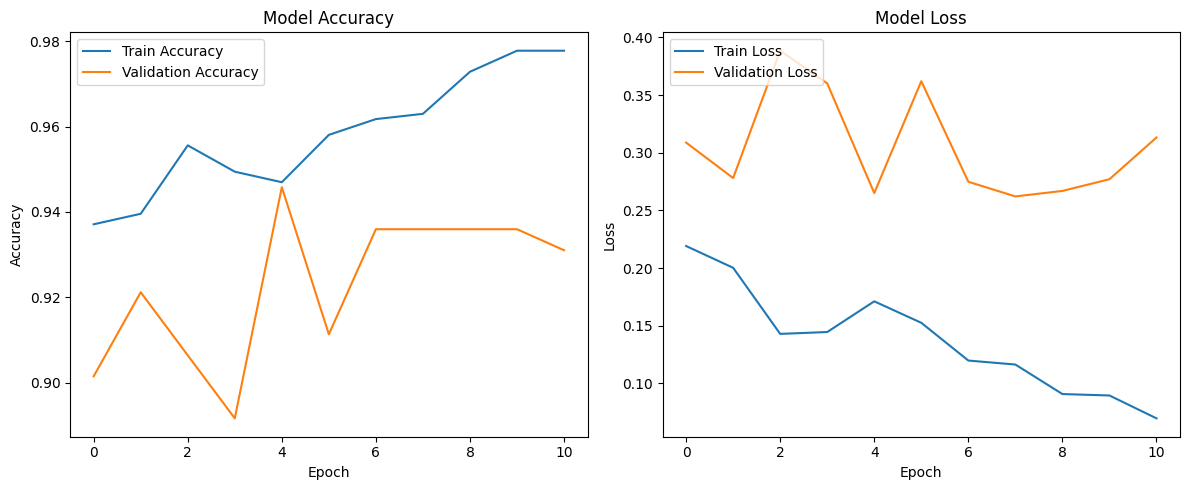

In [15]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])


loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\nTest Loss on the best model: {loss}")
print(f"Test Accuracy on the best model: {accuracy}")


best_model.save("best_multiclass_model.keras")
print("\nBest model saved as 'best_multiclass_model.keras'")


val_acc_epoch = np.argmax(history.history['val_accuracy'])
print(f"Best validation accuracy: {np.max(history.history['val_accuracy']):.4f} at epoch {val_acc_epoch + 1}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Results and Analysis


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step


<Figure size 1000x800 with 0 Axes>

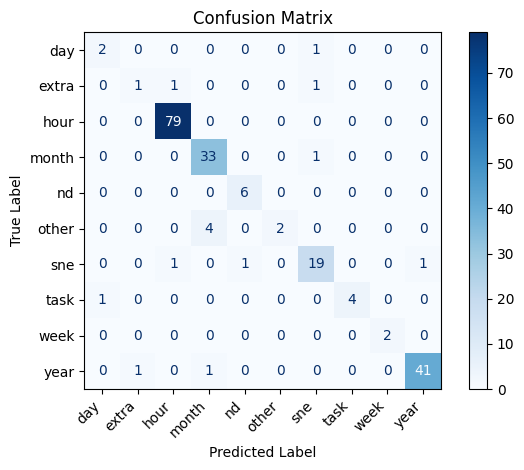


Number of errors per class:
Class 'day': 1 errors
Class 'extra': 2 errors
Class 'hour': 0 errors
Class 'month': 1 errors
Class 'nd': 0 errors
Class 'other': 4 errors
Class 'sne': 3 errors
Class 'task': 1 errors
Class 'week': 0 errors
Class 'year': 2 errors

Class with the most errors: 'other' with 4 errors.


In [16]:
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
unique_true_classes = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred, labels=unique_true_classes)


display_class_labels = label_encoder.inverse_transform(unique_true_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze which class got the most errors
errors_per_class = cm.sum(axis=1) - np.diag(cm)

print("\nNumber of errors per class:")
for i, count in enumerate(errors_per_class):
    print(f"Class '{display_class_labels[i]}': {count} errors")

most_errors_class_index = np.argmax(errors_per_class)
most_errors_class_label = display_class_labels[most_errors_class_index]
most_errors_count = errors_per_class[most_errors_class_index]

print(f"\nClass with the most errors: '{most_errors_class_label}' with {most_errors_count} errors.")


## Overall Performance
The model demonstrates strong performance on the classification task, achieving a final test accuracy of 93.1% and a test loss of 0.313. The training process effectively captured the point of optimal performance, saving the best model at epoch 5 where the validation accuracy peaked at 94.6%.

## Performance by Class
The confusion matrix provides a detailed look at the model's predictions:

* Excellent Performance: The model perfectly classified the hour, nd, and week classes in the test set, with zero errors. It was also highly accurate for the year, month, and sne classes.
* Main Sources of Error: The class with the most errors was other, which was misclassified 4 times, primarily as month. This suggests that the examples in the other category may share linguistic features with the month class. Similarly, the task class was sometimes confused with sne.

## Training Dynamics & Overfitting
The accuracy and loss plots clearly illustrate the model's training behavior:

The training accuracy consistently increased while the training loss steadily decreased, indicating the model was successfully learning from the training data.
However, after epoch 5, the validation accuracy began to decline while the validation loss started to rise. This divergence between the training and validation curves is a classic sign of overfitting.
The strategy of using early stopping—saving the model at the point of highest validation accuracy—was crucial. It prevented the use of a later, overfitted model and ensured the best-generalizing version was selected for testing.

# Conclusion
This project successfully developed a robust multiclass sentence classifier to categorize salary-related text from job descriptions. The final model, a Bidirectional LSTM network optimized with KerasTuner, achieved an impressive test accuracy of 93.1%, demonstrating its effectiveness in understanding the nuanced language of salary specifications.


### The success of this project can be attributed to several key factors:

**Strong Methodological Foundation:** The choice of a Bidirectional LSTM architecture was highly appropriate for this task. As hypothesized, its ability to process text sequentially in both directions allowed the model to effectively capture contextual clues (e.g., distinguishing between "per hour" and "annual salary") that are critical for accurate classification.

**Effective Use of Pre-Trained Embeddings:** Incorporating pre-trained GloVe word embeddings provided the model with a strong initial understanding of language, which is particularly valuable for a specialized, manually-curated dataset of this size. This approach saved significant training time and contributed to the model's high performance.

**Systematic Hyperparameter Optimization:** The project went beyond a baseline model by using KerasTuner to systematically find the optimal hyperparameters. This methodical approach directly resulted in a significant performance boost, increasing the model's accuracy from an initial 89.7% to the final 93.1%.

**Best Practices for Mitigating Overfitting**: The use of Dropout layers and, most critically, Early Stopping, proved essential. The training history plots clearly showed the model beginning to overfit after epoch 5. By implementing early stopping, the project ensured that the final model was saved at its peak validation performance, resulting in a model that generalizes well to unseen data.

### Potential Improvements and Future Work
While the model is highly effective, there are several areas that could be explored to further enhance its performance and capabilities:

**Addressing Class Imbalance:** The exploratory data analysis and confusion matrix revealed a significant imbalance in the dataset, with classes like hour, year, and month having far more samples than biweekly, week, and day. The model's errors were more frequent in these underrepresented classes. Future work could focus on:

**Attention Mechanisms:** Adding an attention layer to the BiLSTM could help the model weigh the importance of specific words (e.g., "annual," "hourly," "per") when making a prediction.
Transformer-Based Models: Fine-tuning a pre-trained transformer model like BERT or DistilBERT could yield state-of-the-art performance. These models are exceptionally powerful at understanding context and have become the standard for many text classification tasks.
Expanding Feature Engineering: The current model relies solely on the salary sentence. Additional features could provide valuable context:

**Numerical Feature Extraction:** Explicitly flagging the presence or absence of digits could provide a simple but powerful signal, especially for distinguishing the nd (No Digits) class.